# Constructing dynamic collaboration networks and calculating social capital using IMDb data
*Julie Nguyen, PhD candidate in Management (Organizational Behavior), McGill University*

Welcome to the second chapter of our exploration into how social networks shape the careers of filmmakers. Our end goal is to uncover whether connections with network brokers — key individuals connecting separate creative circles in the film industry — significantly boost the careers of movie directors, and crucially, whether these effects vary between women and men.

**What are we aiming to do?**

Building on the foundation set in `Phase_1_Tracking_Movie_Directors_Career.ipynb`, where we cataloged films from 2000 to 2023, we now turn our focus to constructing dynamic networks of filmmakers and calculating their yearly brokerage scores over this period. Later on, we'll filter the scores of our directors and their collaborators and examine how they influence directors' career longevity and productivity.

**How do we manage massive data?**

The scale of our data here is enormous — imagine nearly 5 billion potential connections in a yearly network of about 100,000 individuals. Over 23 years, we're looking at up to over 100 billion potential connections. In a network, the relationship between the number of people and potential connections is quadratic. As each new individual joins, the possibilities for new links grow exponentially because each newcomer can connect with all the existing members. 

We’ll employ parallel processing to efficiently manage this enormous dataset. We'll first test our algorithms on a smaller, simulated network that mimics real-world networks, making sure our methodologies works as intended before scaling them to the entire dataset.

In addition, we'll use pandas for data handling, matplotlib for visualization, and networkx for network analysis. 

**Our approach to network analysis:**

1. Who are we including in the network?

We focus on key creative roles — directors, producers, writers, editors, cinematographers, production designers, and composers — who shape the narrative and artistic direction of films.

2. How do we define a connection?

We use a three-year rolling window to capture the evolving nature of professional relationships. Filmmakers are considered connected if they have collaborated at any point during the preceding three years.

3. How do we map a network that is ever changing?

Collaboration networks are in constant flux: some people enter the industry, some people leave it. We capture these shifts by building 21 sequential network graphs, each covering a span of three years. This approach begins with the period from 2000 to 2002, using the data to assess the social capital of individuals in 2003. We continue this process through to 2020-2022, allowing us to determine social capital as it stands in 2023. The idea is that the connections you make in the past three years shape your current social capital.

4. How do we measure brokerage social capital?

To assess the influence and reach of filmmakers within these networks, we calculate brokerage social capital using three key metrics: constraint, effective size, and local clustering. These indicators provide annual insights into the networking prowess of industry professionals.

**Looking ahead**

By the end of this notebook, we'll have calculated the annual brokerage scores for every creative worker in the film industry from 2003 to 2023. This sets the stage for our next phase, where we'll correlate the social capital of directors' collaborators with the directors' career outcomes.

# Identifying creative workers in the film industry (2000-2023)

In this segment, we'll pinpoint the key creative personnel behind the movies released between 2000 and 2023. These individuals represent the nodes in our collaboration networks. We're drawing from two datasets:
- `movies_2000_2023.csv`: a dataset we compiled in the earlier phase `Phase_1_Tracking_Movie_Directors_Career.ipynb`, which documents films released over the last 23 years. 
- `title.principals.tsv.gz`: A comprehensive IMDb dataset detailing the key personnel involved in these productions.

By the end of this segment, we'll have created the `movies_collaborations_2000_2023` dataset. Here's what it includes:
- Movie ID (`tconst`): A unique identifier for each film.
- Person ID (`nconst`): Unique identifiers for each creative worker invovled in these films.
- Role (`category`): This specifies the role each person played, be it director, producer, writer, editor, cinematographer, production designer, or composer.
- Movie Release Year (`startYear`):  The release year of each film.

From this data, we can see who worked with whom, in which capacity, and when, enabling us to build the collaboration networks over time.

In [1]:
# imports libraries
import pandas as pd
import os
import itertools
import networkx as nx
import random
from collections import deque
import multiprocessing as mp
import pickle
import matplotlib.pyplot as plt
import numpy as np

# Setting the working directory to ensure file paths are accessed correctly
os.chdir('/Users/mac/Library/CloudStorage/OneDrive-McGillUniversity/Work/Projects/Gender and brokerage/WomenLeaders_SocialNetworks')

In [15]:
# Loading the dataset of movies released from 2000 to 2023 created previously
movies_2000_2023 = pd.read_csv('movies_2000_2023.csv')

# Displaying the initial rows of the movies dataset to verify correct data loading and format
movies_2000_2023.head()

,tconst,startYear,genres
0,tt0011801,2019.0,"Action,Crime"
1,tt0013274,2021.0,Documentary
2,tt0015414,2000.0,\N
3,tt0028248,2022.0,Musical
4,tt0035423,2001.0,"Comedy,Fantasy,Romance"


In [4]:
# Load the IMDb dataset containing information about key personnel (principals) in movie productions 
# This is to identify creative workers in each film released between 2000 and 2023
url_principals = 'https://datasets.imdbws.com/title.principals.tsv.gz'
df_principals = pd.read_csv(url_principals, sep='\t', compression='gzip', encoding='utf-8', low_memory=False)

# Filter the principals dataset to include only those in creative roles
creative_roles = ['director', 'producer', 'writer', 'editor', 'cinematographer', 'production_designer', 'composer']
df_principals = df_principals[df_principals['category'].isin(creative_roles)]

# Merge the movies dataset with the filtered principals dataset
# This creates a dataset linking movies released between 2000 and 2023 with the creative personnel involved
movies_collaborations_2000_2023 = df_principals[['tconst', 'nconst', 'category']].merge(movies_2000_2023[['tconst', 'startYear']], on='tconst', how='inner')

# Save the merged dataset to a CSV file
movies_collaborations_2000_2023.to_csv('movies_collaborations_2000_2023.csv' , index=False)

In [6]:
# Displaying the initial rows of the merged dataset to ensure the correct merging of movie and personnel data
movies_collaborations_2000_2023.head()

,tconst,nconst,category,startYear
0,tt0011801,nm0483944,writer,2019.0
1,tt0011801,nm1773808,cinematographer,2019.0
2,tt0013274,nm0412842,director,2021.0
3,tt0013274,nm0895048,director,2021.0
4,tt0013274,nm13054604,producer,2021.0


With the `movies_collaborations_2000_2023` data, we have a bipartite network (also called a two-mode network), with each row signifying a link between a creative worker (`nconst`)and a movie (`tconst`), indicating their involvement in that particular movie.

In [7]:
# Calculating and displaying the number of unique movies and creative workers to understand the scope of the dataset
movies_collaborations_2000_2023.nunique()

tconst       296524
nconst       571851
category          7
startYear        24
dtype: int64

Our network comprise 571,851 creative workers who worked on 296,524 movies. Let's count the number of movies and creative personnel, as well as the average size of the creative team per movie for each year. This gives us a sense of the industry's scope and the scale of collaboration over time.

In [18]:
# Aggregating the data by release year count the unique number of movies and creative personnel by year
count_movies_people = movies_collaborations_2000_2023.groupby('startYear').agg(
    num_movies=('tconst', pd.Series.nunique),
    num_creative_workers=('nconst', pd.Series.nunique)
)

# Calculate the average team size by year to gauge collaboration scale
# Group by release year and movie id to count the unique number of people involved in each movie
creative_team_size = movies_collaborations_2000_2023.groupby(['startYear', 'tconst']).nconst.nunique()
# Group by release year again and calculate the average size of these teams for each year
average_creative_team_size = creative_team_size.groupby('startYear').mean().rename('average_creative_team_size')

# Merge the counts and average team size into a single dataframe for analysis
summary_df = pd.merge(count_movies_people, average_creative_team_size, on='startYear').reset_index()

In [19]:
# Displaying the summary DataFrame to review the data on movie production and creative team dynamics from 2000 to 2023.
summary_df

,startYear,num_movies,num_creative_workers,average_creative_team_size
0,2000.0,4919,17914,4.313275
1,2001.0,5337,19201,4.266254
2,2002.0,5496,20038,4.269651
3,2003.0,5698,21288,4.316076
4,2004.0,6321,23662,4.325107
5,2005.0,7225,26717,4.261730
6,2006.0,7859,29483,4.300674
7,2007.0,8461,31641,4.252807
8,2008.0,9879,36051,4.172183
9,2009.0,11330,40796,4.101236


Let's create bar charts to visualize trends in the number of movies, the number of people involved, and the average team size across the years.

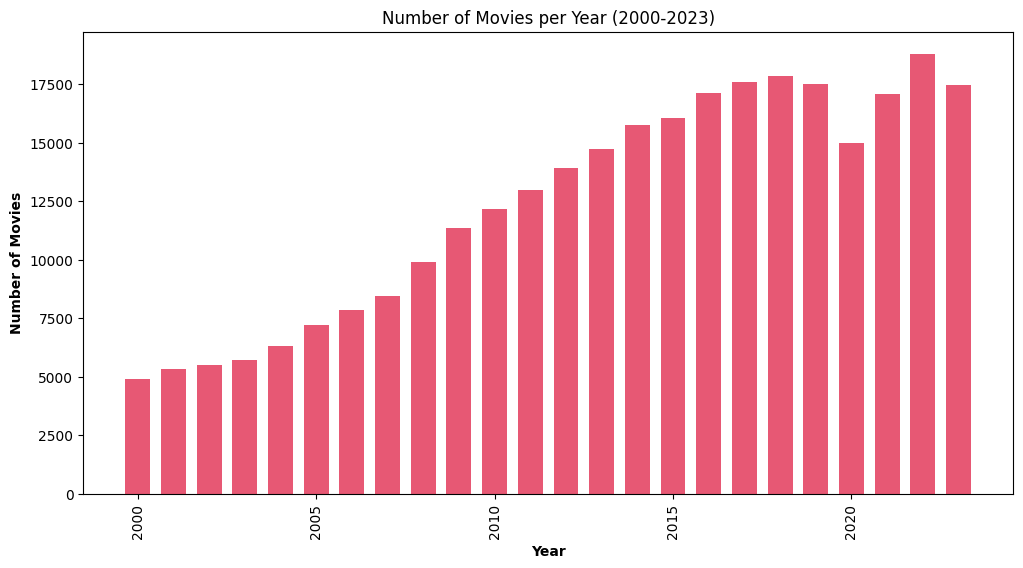

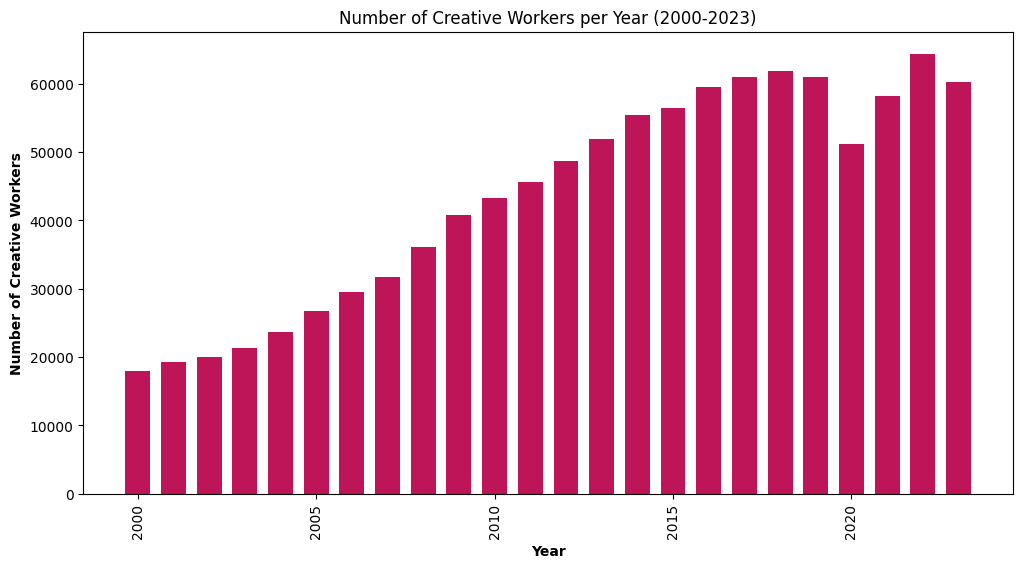

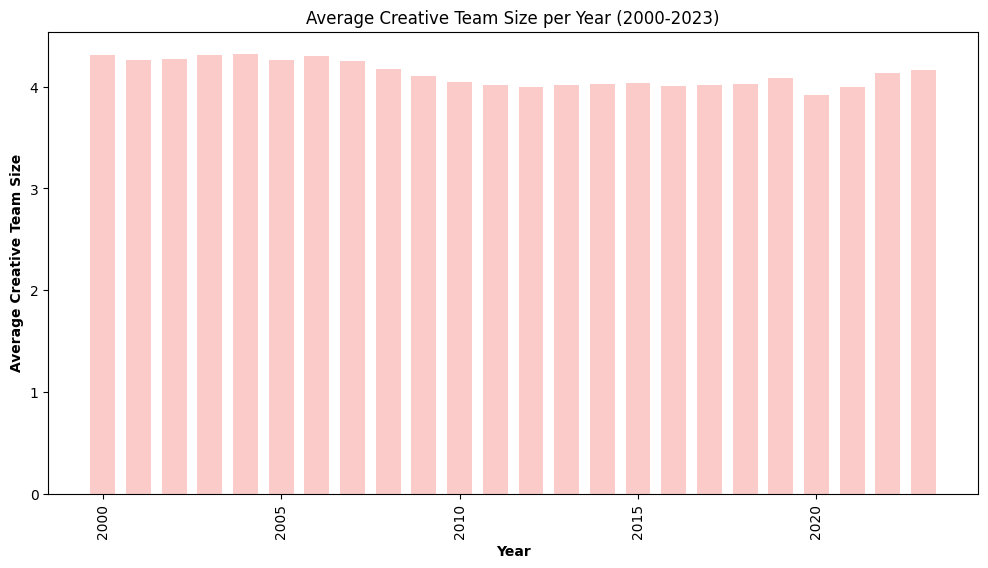

In [21]:
# Visualize the number of movies per year using a bar chart
plt.figure(figsize=(12, 6))
plt.bar(summary_df['startYear'], summary_df['num_movies'], color='#e75874', width=0.7)
plt.xlabel('Year', fontweight='bold')
plt.ylabel('Number of Movies', fontweight='bold')
plt.title('Number of Movies per Year (2000-2023)')
plt.xticks(rotation=90)
plt.show()

# Visualize the number of people (creative personnel) per year using a bar chart
plt.figure(figsize=(12, 6))
plt.bar(summary_df['startYear'], summary_df['num_creative_workers'], color='#be1558', width=0.7)
plt.xlabel('Year', fontweight='bold')
plt.ylabel('Number of Creative Workers', fontweight='bold')
plt.title('Number of Creative Workers per Year (2000-2023)')
plt.xticks(rotation=90)
plt.show()

# Visualize the average team size per year using a bar chart
plt.figure(figsize=(12, 6))
plt.bar(summary_df['startYear'], summary_df['average_creative_team_size'], color='#fbcbc9', width=0.7)
plt.xlabel('Year', fontweight='bold')
plt.ylabel('Average Creative Team Size', fontweight='bold')
plt.title('Average Creative Team Size per Year (2000-2023)')
plt.xticks(rotation=90)
plt.show()

The overall trend shows a significant increase in both the number of movies and the number of creative personnel, highlighting an expanding industry. However, there was a noticeable dip in 2020, likely due to the disruptions caused by the Covid-19 pandemic, with a swift recovery by 2022.

Interestingly, the average size of the creative teams remains relatively constant, suggesting a stable collaboration pattern despite the industry's growth.

# Understanding Network Evolution Through Moving Windows

As we use a three-year moving window to analyze the yearly brokerage social capital of filmmakers, understanding the evolution of this network is crucial. Thus, let's calculate the number of movies, people, and potential connections for each 21 three-year periods starting from 2000-2002 up to 2020-2022:

In [ ]:
# Initialize a list to store counts for each 3-year moving window
window_counts = []

# Loop through each year to calculate the counts for each 3-year moving window
for year in range(2003, 2024):  # From 2003 to 2023
    start_year = year - 3  # Start of the 3-year window
    end_year = year - 1    # End of the 3-year window

    # Filter the data for the current window
    window_data = movies_collaborations_2000_2023[
        movies_collaborations_2000_2023['startYear'].between(start_year, end_year)
    ]

    # Count the unique number of movies and people in the window
    num_movies = window_data['tconst'].nunique()
    num_people = window_data['nconst'].nunique()

    # Append the counts to the list
    window_counts.append({
        'Window Start': start_year,
        'Window End': end_year,
        'Number of Movies': num_movies,
        'Number of People': num_people
    })

# Convert the list of counts into a DataFrame
window_counts_df = pd.DataFrame(window_counts)

# Calculate potential connections for each window
window_counts_df['Potential Connections'] = window_counts_df['Number of People'].apply(lambda n: n * (n - 1) / 2)

In [10]:
window_counts_df

,Window Start,Window End,Number of Movies,Number of People,Potential Connections
0,2000,2002,15752,47308,1.119000e+09
1,2001,2003,16531,50348,1.267435e+09
2,2002,2004,17515,54554,1.488042e+09
3,2003,2005,19244,60562,1.833848e+09
4,2004,2006,21405,67372,2.269460e+09
5,2005,2007,23545,73952,2.734412e+09
6,2006,2008,26199,81723,3.339284e+09
7,2007,2009,29670,91552,4.190839e+09
8,2008,2010,33376,101591,5.160315e+09
9,2009,2011,36485,109737,6.021050e+09


Let's graph these counts to visualize the size of the creative network across different time periods.

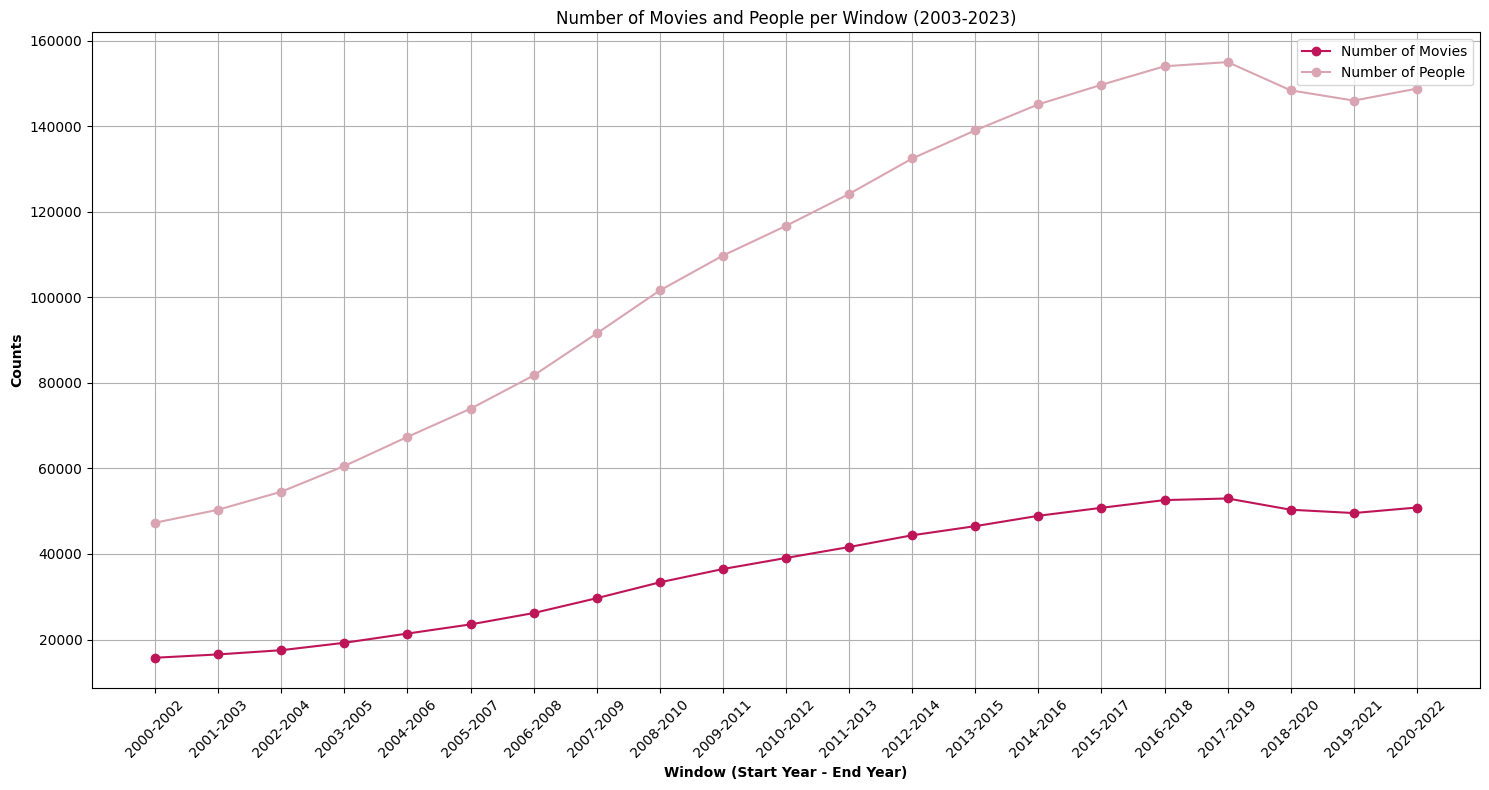

In [13]:
# Visualize the number of movies and people in each 3-year moving window using a line graph
# Set positions of the line points
r1 = np.arange(len(window_counts_df))

# Create the line plots
plt.figure(figsize=(15, 8))
plt.plot(r1, window_counts_df['Number of Movies'], marker='o', color='#be1558', label='Number of Movies')
plt.plot(r1, window_counts_df['Number of People'], marker='o', color='#d9a5b3', label='Number of People')

# Add xticks on the middle of the point groups
plt.xlabel('Window (Start Year - End Year)', fontweight='bold')
plt.ylabel('Counts', fontweight='bold')
plt.xticks(r1, [f"{int(row['Window Start'])}-{int(row['Window End'])}" for _, row in window_counts_df.iterrows()], rotation=45)

# Create legend & Show graphic
plt.legend()
plt.title('Number of Movies and People per Window (2003-2023)')
plt.tight_layout()
plt.grid(True)
plt.show()


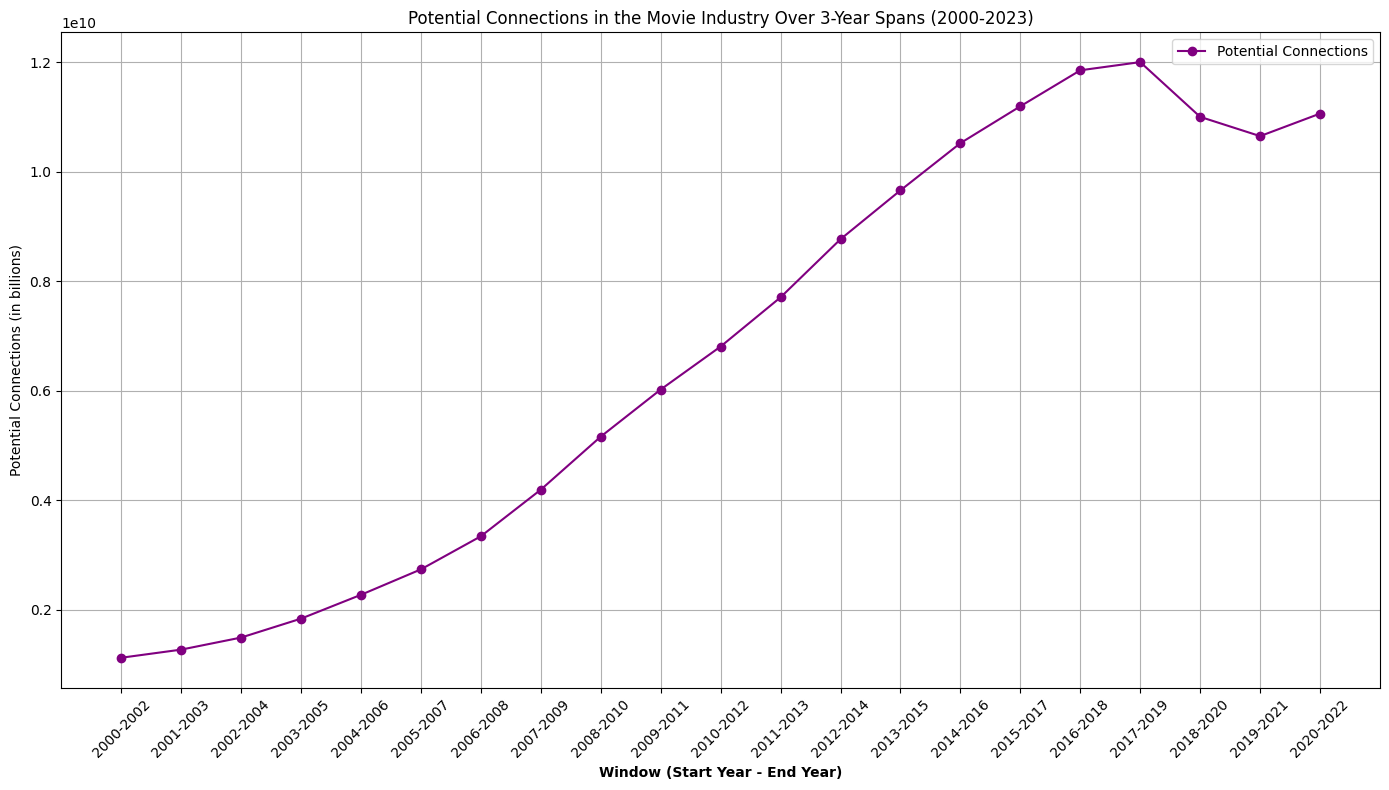

In [15]:
# Set positions of the line points
r1 = np.arange(len(window_counts_df))

# Plotting the potential connections over time with custom x-axis labels
plt.figure(figsize=(14, 8))
plt.plot(r1, window_counts_df['Potential Connections'], marker='o', color='purple', label='Potential Connections')
plt.title('Potential Connections in the Movie Industry Over 3-Year Spans (2000-2023)')
plt.xlabel('Window (Start Year - End Year)', fontweight='bold')
plt.ylabel('Potential Connections (in billions)')

# Set x-ticks to display 'Start Year - End Year' format
plt.xticks(r1, [f"{int(row['Window Start'])}-{int(row['Window End'])}" for _, row in window_counts_df.iterrows()], rotation=45)

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


The smallest network appeared in the 2000-2002 window, with 47,308 creative workers, and the largest in the 2017-2019 window, with 154,952 workers.

The sheer number of potential connections in our analysis windows is astounding, reaching a peak of approximately 12 billion during the 2017-2019 period. This illustrates the quadratic relationship between the number of people and potential connections in a network. As each new individual joins the network, the possibilities for new connections multiply exponentially; every new member has the potential to link with all previously existing members. This exponential growth not only highlights the vast scale of our dataset but also emphasizes the need for strategic approaches in constructing and interpreting these extensive networks.

# Tracking Creative Roles Over Time

Before we do that, I want to know how different creative roles have evolved over the years. Let's start by mapping out the number of people involved in each role through a line graph. This visualization allows us to track growth trajectories of different roles and identify trends in role importance.

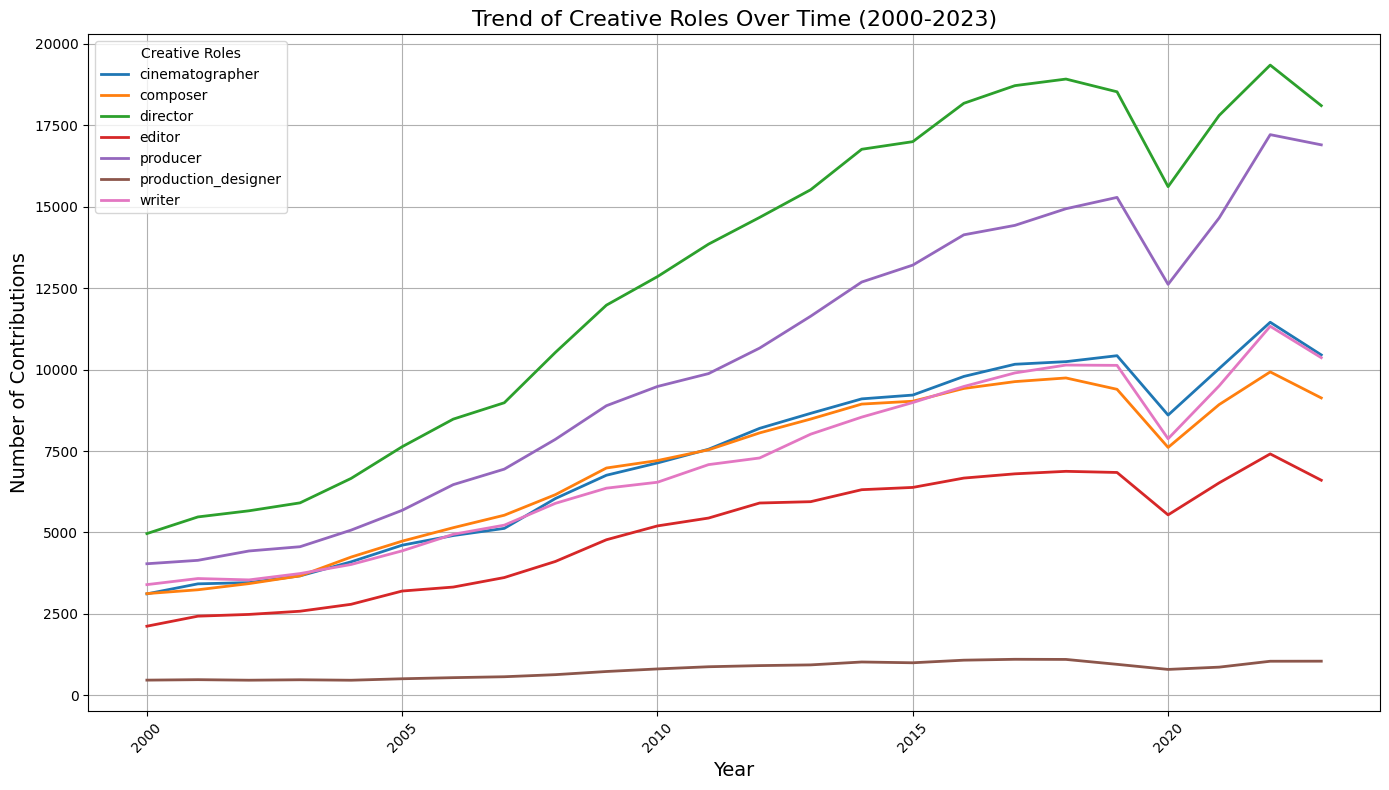

In [5]:
# Group by 'startYear' and 'category' and count the occurrences of each role per year
role_counts = movies_collaborations_2000_2023.groupby(['startYear', 'category']).size().unstack(fill_value=0)

# Plotting each role's involvement over the years using a line graph
plt.figure(figsize=(14, 8))  # Set the figure size for better visibility
for column in role_counts.columns:
    plt.plot(role_counts.index, role_counts[column], marker='', linewidth=2, label=column)

plt.title('Trend of Creative Roles Over Time (2000-2023)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Contributions', fontsize=14)
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.legend(title='Creative Roles')  # Add a legend to distinguish the lines
plt.grid(True)  # Add grid for easier reading
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()


Directors and producers show a pronounced increase, hinting at expanded opportunities and possibly a heightened focus on directing and producing. To quantify this growth, let's calculate the percentage change for each role from 2000 to 2023 and then use a bar chart to visualize the results.

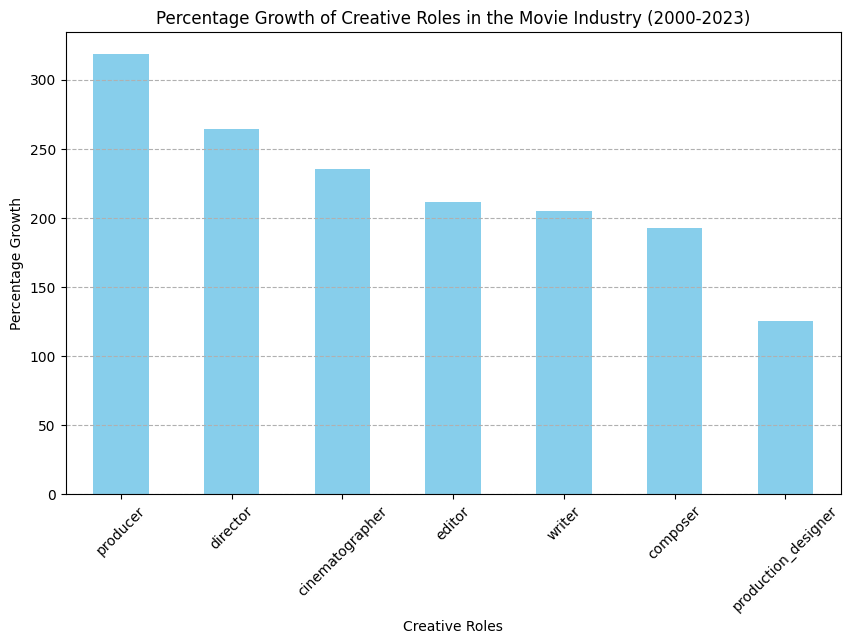

In [7]:
# Calculate percentage change from 2000 to 2023 for each role
percentage_changes = (role_counts.loc[2023] - role_counts.loc[2000]) / role_counts.loc[2000] * 100

# Sorting to find roles with the highest growth
percentage_changes.sort_values(ascending=False, inplace=True)

# Plotting the percentage growth of each role as a bar chart
plt.figure(figsize=(10, 6))
percentage_changes.plot(kind='bar', color='skyblue')
plt.title('Percentage Growth of Creative Roles in the Movie Industry (2000-2023)')
plt.xlabel('Creative Roles')
plt.ylabel('Percentage Growth')
plt.grid(axis='y', linestyle='--')
plt.xticks(rotation=45)
plt.show()

Producers have experienced the most significant growth, around 319%, likely spurred by an increase in production opportunities that come with media diversification, including the rise of streaming platforms. Directors follow closely with a 265% increase, which may reflect growing opportunities for directors and possibly an increased demand for new content. Production Designers, while showing the smallest growth at 125%, still indicate a substantial increase, potentially reflecting an enhanced focus on the visual aspects of production in response to evolving audience expectations.

To further dissect these dynamics, we examine the percentage distribution of roles over three decades using donut charts. Each chart offers a snapshot of the industry's creative backbone during distinct periods.

In [4]:
# Define a function to categorize years into decades
def categorize_decade(year):
    if 2000 <= year <= 2009:
        return "2000-2009"
    elif 2010 <= year <= 2019:
        return "2010-2019"
    elif 2020 <= year <= 2023:
        return "2020-2023"
    else:
        return None

# Apply the categorization function to create a new 'Decade' column
movies_collaborations_2000_2023['Decade'] = movies_collaborations_2000_2023['startYear'].apply(categorize_decade)

# Group by 'Decade' and 'Category' and count occurrences
decade_role_counts = movies_collaborations_2000_2023.groupby(['Decade', 'category']).size().reset_index(name='Count')

# Calculate the total counts per decade for normalization
decade_totals = decade_role_counts.groupby('Decade')['Count'].sum().reset_index(name='Total')

# Merge the counts with totals to calculate percentages
decade_role_percentage = decade_role_counts.merge(decade_totals, on='Decade')
decade_role_percentage['Percentage'] = (decade_role_percentage['Count'] / decade_role_percentage['Total']) * 100

# Check the calculated percentages
decade_role_percentage.sort_values(by=['Decade', 'Percentage'], ascending=False)


,Decade,category,Count,Total,Percentage
16,2020-2023,director,70880,277303,25.560488
18,2020-2023,producer,61393,277303,22.139321
14,2020-2023,cinematographer,40540,277303,14.619387
20,2020-2023,writer,39074,277303,14.090724
15,2020-2023,composer,35595,277303,12.836140
17,2020-2023,editor,26075,277303,9.403072
19,2020-2023,production_designer,3746,277303,1.350869
9,2010-2019,director,165022,627544,26.296483
11,2010-2019,producer,126352,627544,20.134365
7,2010-2019,cinematographer,90485,627544,14.418909


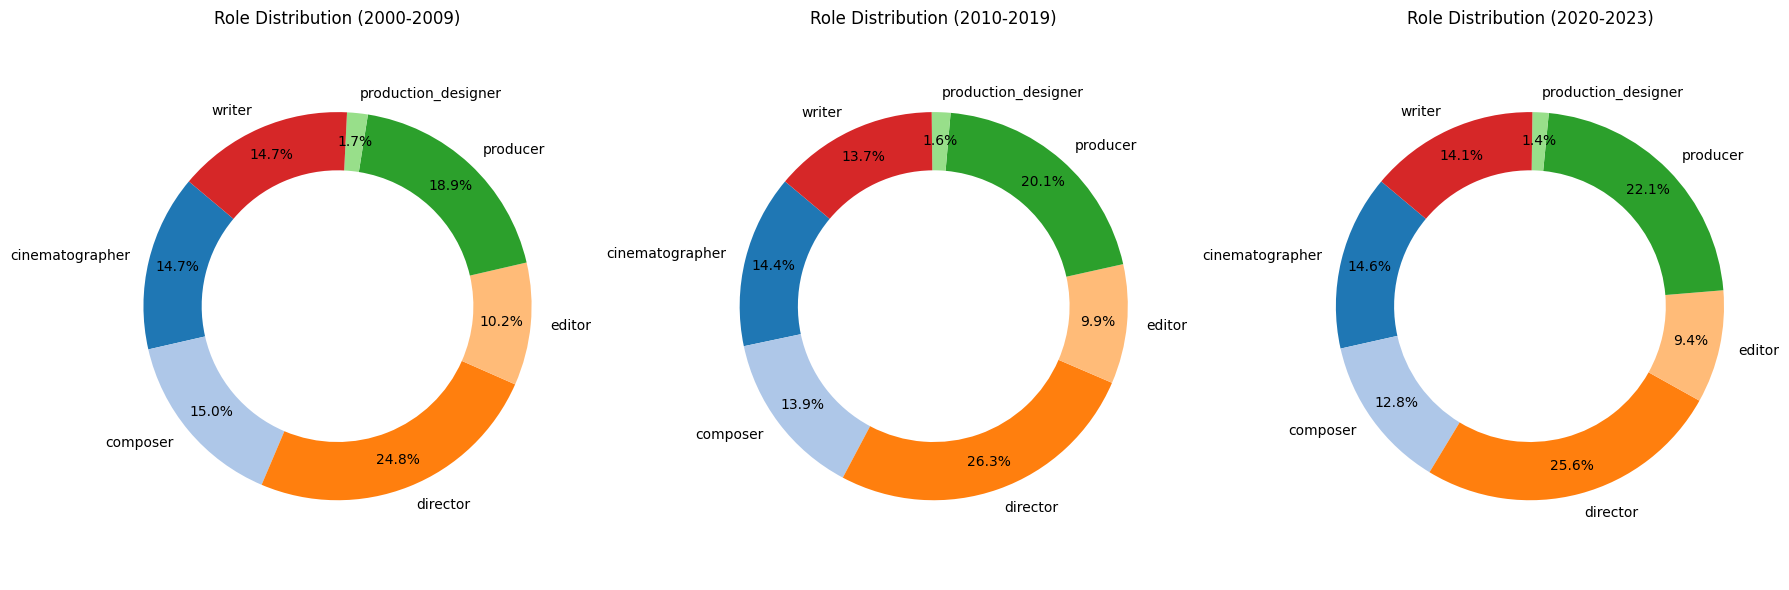

In [5]:
# Function to plot all donut charts side by side using wedgeprops
def plot_all_donut_charts_side_by_side(data):
    # Define the decades
    decades = ["2000-2009", "2010-2019", "2020-2023"]
    colors = plt.cm.tab20.colors  # Define a common color scheme for consistency

    # Create a figure with 3 subplots (axes)
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Loop through each decade and plot on respective ax
    for ax, decade in zip(axes, decades):
        # Filter the data for the specified decade
        decade_data = data[data['Decade'] == decade]
        
        # Plotting the donut chart using wedgeprops
        wedges, texts, autotexts = ax.pie(
            decade_data['Percentage'], labels=decade_data['category'], autopct='%1.1f%%',
            startangle=140, pctdistance=0.85, colors=colors,
            wedgeprops={'width': 0.3}  # Adjust the width to create donut shape
        )

        # Set aspect ratio to ensure pie is drawn as a circle
        ax.axis('equal')
        ax.set_title(f'Role Distribution ({decade})')

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Display the combined plot
    plt.show()

# Plot all donut charts side by side
plot_all_donut_charts_side_by_side(decade_role_percentage)

- Across decades, directors have consistently held the largest share, highlighting their pivotal role in steering the artistic and narrative direction of films. 
- Producers remain the second most prevalent role, highlighting their crucial role in managing everything from logistics to finances, ensuring that projects are not only envisioned but also realized.
- Additionally, there is a notable balance in the percentage among cinematographers, who provide the visual storytelling elements; writers, who craft the underlying stories, and composers, who enhance the emotional and thematic depth of films through music.

# Constructing dynamic collaboration network and calculating brokerage social capital 

With our exploration of creative roles complete, let’s shift our focus to the main task of this notebook: building the dynamic collaboration networks within the film industry and calculate the brokerage social capital for every creative worker involved. From there, we will later obtain the brokerage scores of the directors's collaborators, which will then be used to predict their career longevity.

## Implementing a Three-Year Moving Window

We use a three-year moving window to calculate each person's brokerage social capital, examining their collaborations in the years leading up to the target year. For instance, to calculate the social capital for 2003, we look at collaborations from 2000 to 2002. Then, to calculate the social capital for 2004, we look at collaborations from 2001 to 2003, and so on. This method captures the evolving dynamics of the network, reflecting both the dissolution of old ties and the formation of new ones as we move through the timeline up to 2023.

## Transforming Data for Network Analysis

Starting with our `movies_collaborations_2000_2023` dataset, which forms a bipartite network of movies and people, our task is to convert this into an edge list for each year. Each edge represents a collaboration between two individuals. We then aggregate edges from three consecutive years to construct a comprehensive network graph for each window, to which we can apply network analysis techniques to compute brokerage scores for everyone in the network.

## Automating and Accelerating the Calculation of Brokerage Social Capital

Given the vast scale of our 21 networks, which encompass up to 150,000 individuals and potentially 12 billions of connections, manual analysis is not only impractical but also prone to errors. To streamline this process, let's create a function named `calculate_social_capital`. This function is designed to automate the construction of networks for each year from 2003 to 2023 by pulling collaboration data from the preceding three years and to compute several metrics of brokerage social capital:
- Constraint: How much a person’s network contacts are connected to each other, potentially limiting their brokerage opportunities.- Effective Size: The number of unique, non-redundant connections a person has.
- Local Clustering: The extent to which a person’s network contacts tend to cluster together.


In [3]:
# Define a function to calculate various brokerage social capital metrics for a specified year and set of edges
# This function is placed in a separate Python script named "network_analysis_function.py" for parallel processing
def calculate_social_capital(year, edges_by_year):
    
    # Initialize a rolling window to accumulate edges over a 3-year period
    rolling_edges = deque()

    # For each year in the 3-year window leading up to the focal year, add the edges to the rolling window
    for y in range(year - 3, year):
        edges = edges_by_year.get(y, []) # Retrieve edges for the year 'y', defaulting to an empty list if not found
        rolling_edges.extend(edges) # Add these edges to the rolling window
    
    # Create a graph (network) using the edges accumulated in the rolling window
    G = nx.Graph()
    G.add_edges_from(rolling_edges) # Add the edges to the graph
    
    # Calculate brokerage scores for the nodes
    brokerage_scores = {
        # Constraint measures the extent to which a node's connections are to others that are connected to each other
        'constraint': nx.constraint(G), 
        # Effective size is a measure of the number of non-redundant contacts a node has
        'effective_size': nx.effective_size(G), 
        # Betweenness centrality measures the extent to which a node lies on shortest paths between other nodes
        'betweenness_centrality': nx.betweenness_centrality(G), 
        # Local clustering coefficient measures the degree to which nodes in a graph tend to cluster together
        'local_clustering': nx.clustering(G) 
    }
    return year, brokerage_scores

Now, we can apply this function to each window manually. But we can also speed up the total computation time with parallel processing. It's like an assembly line in a factory, where the task of constructing each network and computing social capital metrics for everyone in the network is distributed across multiple workers/processors. 

To optimize performance in the Jupyter Notebook environment—which excels at interactive analysis but struggles with intensive parallel processing—we externalize our main functions, `calculate_social_capital` and its wrapper `calculate_social_capital_wrapper`, into separate Python scripts (`network_analysis_function.py` and `parallel_functions.py`). This separation ensures that each processor can independently access and execute these functions without the typical limitations encountered within notebooks.

In [ ]:
# Wrapper function for parallel processing
# This function is placed in a separate Python script named "parallel_functions.py" for parallel processing
def calculate_social_capital_wrapper(year, edges_by_year):
    # Call the main function to calculate social capital metrics for a given year and its edges
    return calculate_social_capital(year, edges_by_year)

## Preparing Our Tools: Testing with a Simulated Network

Before diving into the vast ocean of our real-world data, let's dip our toes in a more controlled environment with a toy example. This simulated, scaled-down network mimics the complex interactions within the film industry, allowing us to refine our methods in a manageable setting.

Here are what we will do to construct our simulated miniature network:

1. *Setting Time Frame and Volume:*: We construct a scenario from 2000 to 2006, producing two fictional movies each year. This time frame is compact yet sufficient to test the dynamics of our analysis tools.

2. *Populating the Network:* We populate this mini-universe with a set of characters: 'person1' through 'person11'. Key players like 'person1', 'person2', and 'person3' are more prominent, mimicking real-world scenarios where certain individuals are central to multiple projects.

3. *Generating Collaborations:* For each movie, a randomly determined subset of our cast comes together, ensuring both a mix of regular and key participants. This randomness introduces the necessary variability that exists in real-world collaborations.

4. *Forming connections:* We then create pairs from these selected individuals to represent collaborative ties, like how people in the film industry might work together on various projects. These connections are what we'll use to construct the networks.

5. *Restructuring the simulated data:* Finally, we transform the simulated data into a formet that mirrors our actual data (`movies_collaborations_2000_2023`), so that each row a link between a person (`nconst`)and a movie (`tconst`) along with the movie release year (`startYear`). This ensures our codes are applicable to our real data.

In [4]:
# Create a toy example to test and validate the function before applying it to the real dataset

# Settings for the toy example
years = range(2000, 2006) # Define the range of years
movies_per_year = 2 # Define the number of movies per year
people = ['person' + str(i) for i in range(1, 12)]  # Create a list of people identifiers
key_players = ['person1', 'person2', 'person3']  # Define key players who appear more frequently

# Generate random collaborations
data = []
for year in years:
    for movie_number in range(1, movies_per_year + 1):
        movie_id = f"movie_{year}_{movie_number}" # Construct a movie identifier
        num_people = random.randint(4, 9)  # Choose a random number of people for variability
        selected_people = random.sample(people, num_people) # Randomly select people to be involved in the movie
        selected_people.extend(random.sample(key_players, 1))  # Ensure inclusion of at least one key player
        selected_people = list(set(selected_people))  # Remove any duplicate people
        # Create pairs of people to represent collaborations
        for collaboration in itertools.combinations(selected_people, 2):
            data.append({'tconst': movie_id, 'startYear': year, 'nconst1': collaboration[0], 'nconst2': collaboration[1]})

# Convert the toy data into a DataFrame
toy = pd.DataFrame(data)

# Reshape the DataFrame to have all pairs in a single column
pairs_data = []
for _, row in toy.iterrows():
    pairs_data.append([row['tconst'], row['startYear'], row['nconst1']])
    pairs_data.append([row['tconst'], row['startYear'], row['nconst2']])

# Reformat the toy data into the final structure
toy = pd.DataFrame(pairs_data, columns=['tconst', 'startYear', 'nconst'])


Let's see what our toy data looks like:

In [5]:
toy

,tconst,startYear,nconst
0,movie_2000_1,2000,person2
1,movie_2000_1,2000,person4
2,movie_2000_1,2000,person2
3,movie_2000_1,2000,person3
4,movie_2000_1,2000,person2
...,...,...,...
461,movie_2005_2,2005,person9
462,movie_2005_2,2005,person1
463,movie_2005_2,2005,person8
464,movie_2005_2,2005,person9


Looks good! With this simulated small-scale network in hand, let's test our functions for calculating yearly brokerage social capital. 

## Testing the Toy Example with Parallel Processing

1. *Importing the function to calculate brokerage*: We start by importing the `calculate_social_capital_wrapper` function, a function crafted to facilitate the computation of social capital metrics efficiently across multiple processors. This function acts as a bridge, ensuring smooth execution of our main function, `calculate_social_capital`. 

2. *Building an edgelist for each year in the data*: We define the `create_pairs` function to generate a detailed list of collaborative ties for each group of participants by movie and year. This creates the input for our social capital calculation.

3. *Setting up parallel processing*: We initiate a multiprocessing pool, paralleling an assembly line where multiple workers (processors) handle different parts of the task concurrently. This significantly reduces computation time and enhances efficiency.

4. *Running the calculations*: Using pool.starmap, we execute our brokerage calculation across the defined years, ensuring each year's network is analyzed in parallel for speed and efficiency.

5. *Collecting and reviewing the Results*: After processing, we compile the brokerage scores for each year into a dictionary, `brokerage_scores_by_year`.

In [6]:
# Process the toy example data to calculate brokerage scores using parallel processing

# Import the wrapper function for calculating brokerage social capital for parallel processing
from parallel_functions import calculate_social_capital_wrapper 

# Define a function to create pairs of collaborators from the toy data
def create_pairs(group):
    # For each group of data, create all possible pairs of collaborators
    return pd.DataFrame(itertools.combinations(group['nconst'], 2), columns=['person1', 'person2'])

# Main execution block
if __name__ == "__main__":
    # Group the toy data by movie and year, and apply the pair creation function
    toy = toy.groupby(['tconst', 'startYear']).apply(create_pairs).reset_index().drop('level_2', axis=1)
    # Organize the edges by year for the toy data
    edges_by_year = {year: group[['person1', 'person2']].values for year, group in toy.groupby('startYear')}
    
    # Create a multiprocessing pool for parallel processing
    pool = mp.Pool(mp.cpu_count())
    # Define the years to process for the toy example
    years = range(2003, 2006)

    # Calculate brokerage scores for each year in parallel
    results = pool.starmap(calculate_social_capital_wrapper, [(year, edges_by_year) for year in years])
    # Close the pool and wait for all processes to finish
    pool.close()
    pool.join()
    
    # Collect the calculated brokerage scores by year
    brokerage_scores_by_year = {year: scores for year, scores in results}

/var/folders/1j/csv118695x53qkzhd9p2tgcc0000gn/T/ipykernel_1247/74822363.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  toy = toy.groupby(['tconst', 'startYear']).apply(create_pairs).reset_index().drop('level_2', axis=1)


Let's review these scores to see whether our functions are performing as expected.

In [7]:
brokerage_scores_by_year

{2003: {'constraint': {'person2': 0.3649243318664806,
   'person4': 0.3649243318664806,
   'person3': 0.3649243318664806,
   'person10': 0.3649243318664806,
   'person9': 0.3784793388429753,
   'person1': 0.3784793388429753,
   'person5': 0.3784793388429753,
   'person6': 0.3649243318664806,
   'person8': 0.3784793388429753,
   'person7': 0.4071994795556947,
   'person11': 0.3649243318664806},
  'effective_size': {'person2': -0.1999999999999993,
   'person4': -0.1999999999999993,
   'person3': -0.1999999999999993,
   'person10': -0.1999999999999993,
   'person9': -1.0,
   'person1': -1.0,
   'person5': -1.0,
   'person6': -0.1999999999999993,
   'person8': -1.0,
   'person7': -1.0,
   'person11': -0.1999999999999993},
  'betweenness_centrality': {'person2': 0.014814814814814815,
   'person4': 0.014814814814814815,
   'person3': 0.014814814814814815,
   'person10': 0.014814814814814815,
   'person9': 0.0,
   'person1': 0.0,
   'person5': 0.0,
   'person6': 0.014814814814814815,
   'pers

Everything looks good! Now, we can proceed to apply these functions to our actual dataset of movie collaborations.

## Applying the functions to the real dataset

We apply the same processes to our actual dataset of movie collaborations, i.e., `movies_collaborations_2000_2023`, which contains information about individuals who have worked on movies released between 2000 and 2023. By the end, we'll have the brokerage social capital scores for each individual in the network, for each year from 2003 to 2023. 

These scores stored in a dictionary (`brokerage_scores_by_year`) where they are arranged in a format that pairs each calendar year (like 2003, 2004, and so on) with a specialized set of metrics for individuals active during that time ("constraint", "effective size", and "local clustering"). Each person in this dataset is uniquely identified by a code (`nconst`), linking them to their specific scores in a specific year.

This dictionary is saved as a digital file named `brokerage_scores_by_year.pkl`. Pickle, being a Python-specific format, is great at handling complex data structures such as our brokerage scores dictionary, ensuring the data can be quickly accessed and used for future analysis. 

In [ ]:
# Apply the same process to the actual dataset of movie collaborations
# Load the real dataset containing movie collaborations from 2000 to 2023
movies_collaborations_2000_2023 = pd.read_csv('movies_collaborations_2000_2023.csv')

from parallel_functions import calculate_social_capital_wrapper 

def create_pairs(group):
    return pd.DataFrame(itertools.combinations(group['nconst'], 2), columns=['person1', 'person2'])

if __name__ == "__main__":
    # Group the real dataset by movie and year, and create pairs of collaborators
    movies_collaborations_2000_2023 = movies_collaborations_2000_2023.groupby(['tconst', 'startYear']).apply(create_pairs).reset_index().drop('level_2', axis=1)
    # Organize the edges by year 
    edges_by_year = {year: group[['person1', 'person2']].values for year, group in movies_collaborations_2000_2023.groupby('startYear')}

    # Create a multiprocessing pool for parallel processing
    pool = mp.Pool(mp.cpu_count())
    # Define the years to process
    years = range(2003, 2024)
    
    # Calculate brokerage scores for each year in parallel 
    results = pool.starmap(calculate_social_capital_wrapper, [(year, edges_by_year) for year in years])
    # Close the pool and wait for all processes to finish
    pool.close()
    pool.join()

    # Collect the calculated brokerage scores by year 
    brokerage_scores_by_year = {year: scores for year, scores in results}
    
    # Save the calculated brokerage scores as a pickle file for future use
    with open('brokerage_scores_by_year.pkl', 'wb') as f:
        pickle.dump(brokerage_scores_by_year, f)

Let's see if we have brokerage scores for all the years in our observation period (2003-2023).

In [8]:
list(brokerage_scores_by_year.keys())

[2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2021,
 2022,
 2023]

Yup, all the years are present in our data! In future analyses, we can use this file to get the yearly brokerage scores of the directors and their collaborators.